In [1]:
from sktime.datasets import load_forecastingdata
import pandas as pd

data = load_forecastingdata("australian_electricity_demand_dataset")[0]
data = data.set_index("series_name")
series = data.loc["T1"]["series_value"]
y = pd.DataFrame(series, index=pd.date_range("2006-01-01", periods=len(series), freq="30min"))
y = y.resample("H").mean()

series = data.loc["T2"]["series_value"]
y2 = pd.DataFrame(series, index=pd.date_range("2006-01-01", periods=len(series), freq="30min"))
y2 = y.resample("H").mean()


/var/folders/cc/5hvg7_bn5kzdnfdwjr9bbvcm0000gn/T/ipykernel_6170/2718765732.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.resample("H").mean()
/var/folders/cc/5hvg7_bn5kzdnfdwjr9bbvcm0000gn/T/ipykernel_6170/2718765732.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y2 = y.resample("H").mean()


/Users/benediktheidrich/code/sktime/venv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/benediktheidrich/code/sktime/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/benediktheidrich/code/sktime/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='0'>)

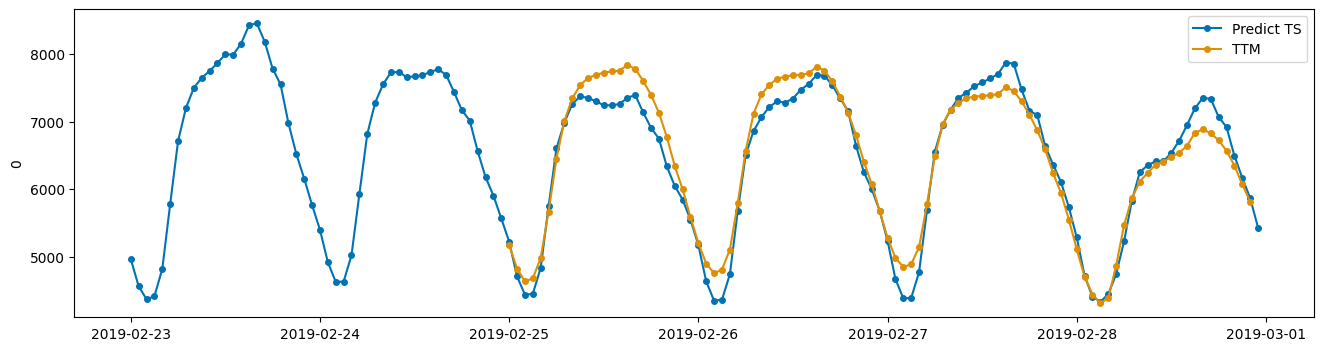

In [2]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
from sktime.utils.plotting import plot_series

ttm = TinyTimeMixerForecaster()
ttm.fit(y=y, fh=range(1, 96))
pred_ttm = ttm.predict(y=y[:-96])

plot_series(y[-48 * 3:], pred_ttm,  labels=["Predict TS", "TTM"])


In [3]:
ttm.model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [4]:
from sktime.forecasting.peft_forecaster import PEFTForecaster
from peft import LoraConfig, TaskType
model_name_or_path = "bigscience/mt0-large"
tokenizer_name_or_path = "bigscience/mt0-large"

peft_config = LoraConfig(
    #task_type=TaskType.CAUSAL_LM,
    r=8, lora_alpha=32, lora_dropout=0.1,
    target_modules = ["fc1"]

)

ttm = TinyTimeMixerForecaster()

peft_forecaster = PEFTForecaster(ttm, peft_config=peft_config, training_args={"output_dir": ".",
                                                                              "per_device_train_batch_size" : 128}, device="mps")

peft_forecaster.fit(y[:-96], fh=range(1, 96))



/Users/benediktheidrich/code/sktime/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/benediktheidrich/code/sktime/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/2148 [00:00<?, ?it/s]

{'loss': 323759.36, 'grad_norm': 110525.359375, 'learning_rate': 3.836126629422719e-05, 'epoch': 0.7}
{'loss': 317139.872, 'grad_norm': 107113.4765625, 'learning_rate': 2.672253258845438e-05, 'epoch': 1.4}
{'loss': 312900.128, 'grad_norm': 98521.5859375, 'learning_rate': 1.5083798882681566e-05, 'epoch': 2.09}
{'loss': 309807.808, 'grad_norm': 107864.0, 'learning_rate': 3.445065176908752e-06, 'epoch': 2.79}
{'train_runtime': 112.2834, 'train_samples_per_second': 2447.646, 'train_steps_per_second': 19.13, 'train_loss': 315573.5921787709, 'epoch': 3.0}


PEFTForecaster(device='mps', model=TinyTimeMixerForecaster(),
               peft_config=LoraConfig(peft_type=<PeftType.LORA: 'LORA'>,
                                      auto_mapping=None,
                                      base_model_name_or_path='ibm/TTM',
                                      revision=None,
                                      task_type=None,
                                      inference_mode=False,
                                      r=8,
                                      target_modules={'fc1'},
                                      lora_alpha=32,
                                      lora_dropout=0.1,
                                      fan_in_fan_out=False,
                                      bias='none',
                                      use_rslora=False,
                                      modules_to_save=None,
                                      init_lora_weights=True,
                                      layers_to_transform=None,
                                      layers_pattern=None,
                                      rank_pattern={},
                                      alpha_pattern={},
                                      megatron_config=None,
                                      megatron_core='megatron.core',
                                      loftq_config={},
                                      use_dora=False,
                                      layer_replication=None,
                                      runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False)),
               training_args={'output_dir': '.',
                              'per_device_train_batch_size': 128})

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='0'>)

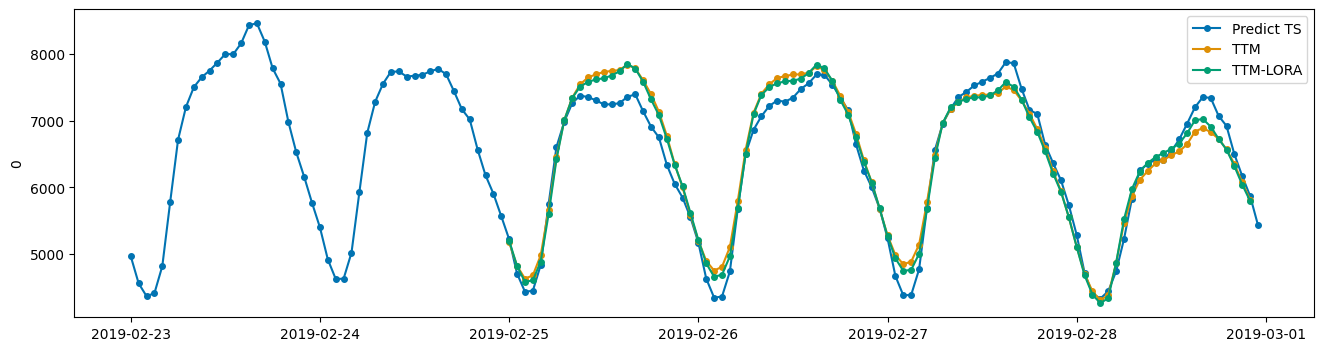

In [5]:
pred_ttm_lora = peft_forecaster.predict(y=y[:-96])

plot_series(y[-48 * 3:], pred_ttm,  pred_ttm_lora, labels=["Predict TS", "TTM", "TTM-LORA"])
